In [1]:
import sys
import os

galax_module_path = os.path.abspath(os.path.join('..'))
if galax_module_path not in sys.path:
    sys.path.append(galax_module_path)

import galaxies_data as galax
from matplotlib import pyplot as plt
import tensorflow.compat.v2 as tf
import functools
from absl import logging
import pandas as pd
import tensorflow_addons as tfa
import albumentations as A
import numpy as np

/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201129). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
def bulid_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        logging.info('Global batch size: %d', global_batch_size)
        logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_pretrain = get_preprocess_fn(True, is_pretrain=True)
        num_classes = 5

        def map_fn(image, label):
            #Produces multiple transformations of the same batch for pretraining
            xs = []
            for _ in range(2):
                xs.append(preprocess_fn_pretrain(image))
            image = tf.concat(xs, -1)
            label = tf.one_hot(label, num_classes)
            return image, label

        logging.info('Using Astro pretrain data')
        dataset = get_data_train()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat(-1)
        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = bulid_input_fn(batch_size)
    return strategy.distribute_datasets_from_function(input_fn)

def get_preprocess_fn(is_training, is_pretrain):
    #Get function that accepts an image and returns a preprocessed image
    test_crop=True
    return functools.partial(
        preprocess_image,
        height = 330,
        width= 330,
        color_distort=is_pretrain)


def get_data_train():
    logging.info('Loading Astro pretrain data')
    data_dir = '/home/pedri0/Documents/imagenes_no_clasificadas_desi/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('/home/pedri0/Documents/GitHub/Modified-SimCLR/SimCLRTF2/galaxies_train.csv')
    file_paths = df['name'].values
    labels = tf.zeros([df.shape[0]], dtype=tf.int64)
    ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_train = ds_train.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_train

CROP_PROPORTION = 0.55

def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(
          tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
          tf.cast(p, tf.float32)), lambda: func(x), lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random.uniform([], tf.maximum(1.0 - max_delta, 0),
                               1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = tf.image.random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image, strength, random_order=True, impl='simclrv2'):
  """Distorts the color of the image.

  Args:
    image: The input image tensor.
    strength: the floating number for the strength of the color augmentation.
    random_order: A bool, specifying whether to randomize the jittering order.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    The distorted image tensor.
  """
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(
        image, brightness, contrast, saturation, hue, impl=impl)
  else:
    return color_jitter_nonrand(
        image, brightness, contrast, saturation, hue, impl=impl)


def color_jitter_rand(image,
                      brightness=0,
                      contrast=0,
                      saturation=0,
                      hue=0,
                      impl='simclrv2'):
  """Distorts the color of the image (jittering order is random).

  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness, impl=impl)

      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random.shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  """Compute aspect ratio-preserving shape for central crop.

  The resulting shape retains `crop_proportion` along one side and a proportion
  less than or equal to `crop_proportion` along the other side.

  Args:
    image_height: Height of image to be cropped.
    image_width: Width of image to be cropped.
    aspect_ratio: Desired aspect ratio (width / height) of output.
    crop_proportion: Proportion of image to retain along the less-cropped side.

  Returns:
    crop_height: Height of image after cropping.
    crop_width: Width of image after cropping.
  """
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(
        tf.math.rint(crop_proportion / aspect_ratio * image_width_float),
        tf.int32)
    crop_width = tf.cast(
        tf.math.rint(crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.math.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(
        tf.math.rint(crop_proportion * aspect_ratio * image_height_float),
        tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.

  See `tf.image.sample_distorted_bounding_box` for more documentation.

  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope or 'distorted_bounding_box_crop'):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.

  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.

  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize([image], [height, width],
                         method=tf.image.ResizeMethod.BICUBIC)[0]


def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.

  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0, impl='simclrv2'):

  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=0.5, impl=impl)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def preprocess_for_train(image,
                         height,
                         width,
                         color_distort=True,
                         crop=True,
                         flip=True,
                         impl='simclrv2'):
  """Preprocesses the given image for training.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    color_distort: Whether to apply the color distortion.
    crop: Whether to crop the image.
    flip: Whether or not to flip left and right of an image.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image, impl=impl)

  image = tf.py_function(aug_fn, inp=[image, 330], Tout=tf.float32)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, color_distort=True):
  """Preprocesses the given image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    is_training: `bool` for whether the preprocessing is for training.
    color_distort: whether to apply the color distortion.
    test_crop: whether or not to extract a central crop of the images
        (as for standard ImageNet evaluation) during the evaluation.

  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return preprocess_for_train(image, height, width, color_distort)



def aug_fn(image, img_size):
  image = image.numpy()
  image *= 255
  image = image.astype(np.uint8)
    #if image.shape == (800,800):
  data = {"image":image}
  transforms = transformations(image.shape[0])
  aug_data = transforms(**data)
  aug_img = aug_data["image"]
  aug_img = tf.cast(aug_img/255.0, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
  return aug_img


def transformations(im_size):
  transforms = A.Compose([
        #A.Rotate(limit=40, border_mode=2),

        #uint8, float32
        #A.Resize(330,330, p=1.0), #aveces tira error porque hay imagenes de 256x256 al parecer
        #uint8, float32 recommended uint8
        #A.CenterCrop(400, 400, p=1.0),
        #A.CenterCrop(int(im_size/1.5), int(im_size/1.5), p=1.0),
        #uint8, float32
        #.RandomSizedCrop(p=1.0, min_max_height=(int(im_size/3.5), int(im_size/1.35)), height=100, width=100),
        #A.RandomCrop(p=1.0, height=100, width=100),
        #uint8, float32
        A.Flip(p=1.0),
        A.ChannelShuffle(p=0.1),
        #.RandomGamma(p=0.8, gamma_limit=[85, 115]),
        #uint8, float32
        #.RandomBrightness(limit=[-0.1,0.1], p=0.8), #THIS!!!!
        #uint8, float32
        #.RandomContrast(p = 0.8),
        #uint8, float32
        #.HueSaturationValue(p = 0.8),
        #uint8, float32
        #A.ToGray(p=1.0),
        #uint8, float32
        #A.GaussianBlur(p=1, blur_limit=[5,11]),
        #uint8, float32
        A.Solarize(p=0.2),
        A.MotionBlur(p=0.5, blur_limit=13),
        #any
        
        #A.CoarseDropout(p=0.3, max_holes=20, max_height=16, max_width=16, min_holes=10, min_height=8, min_width=8)
        #A.Equalize(p=1,by_channels=True) #no usar!
        #
  ])
  return transforms

In [71]:
def random_apply(func, p, x):
    #Random apply function funt to x with probability p.
    return tf.cond(
        tf.less(
            tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
            tf.cast(p, tf.float32)
        ), lambda: func(x), lambda: x
    )

def random_brightness(image, max_delta):
    factor = tf.random.uniform([], tf.maximum(1.0 - max_delta, 0),1.0 + max_delta)
    image = image * factor
    return image

def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.tile(image, [1, 1, 3])
    return image

def color_jitter(image, strength):
    #Distorts the color of the image.

    #Args:
        #image: The input image tensor.
        #strength: the floating number for the strength of the color augmentation.
        #random_order: A bool, specifying whether to randomize the jittering order.

    #Returns: The distorted image tensor.
    brightness = 0.8 * strength
    contrast = 0.8 * strength
    saturation = 0.8 * strength
    hue = 0.2 * strength
    return color_jitter_rand(image, brightness, contrast, saturation, hue)

def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
    #Distorts the color of the image (jittering order is random).

    #Args.
        #image: The input image tensor.
        #brightness: A float, specifying the brightness for color jitter.
        #contrast: A float, specifying the contrast for color jitter.
        #saturation: A float, specifying the saturation for color jitter.
        #hue: A float, specifying the hue for color jitter.

    #Returns.
        #The distorted image tensor.

    with tf.name_scope('distort_color'):

        def apply_transform(i, x):
           #Apply the i-th transformation
            def brightness_foo():
                if brightness == 0:
                    return x
                else:
                    return random_brightness(x, max_delta=brightness)
            
            def contrast_foo():
                if contrast == 0:
                    return x
                else:
                    return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
            
            def saturation_foo():
                if saturation == 0:
                    return x
                else:
                    return tf.image.random_saturation(x, lower=1-saturation, upper=1+saturation)
                
            def hue_foo():
                if hue == 0:
                    return x
                else:
                    return tf.image.random_hue(x, max_delta=hue)
            
            x = tf.cond(tf.less(i, 2),
                    lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                    lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
            
            return x

        perm = tf.random.shuffle(tf.range(4))
        for i in range(4):
            image = apply_transform(perm[i], image)
            image = tf.clip_by_value(image, 0., 1.)

        return image

def distorted_bounding_box_crop(image, bbox, min_object_covered=0.1, aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0), max_attempts=100, scope=None):
    #Generates cropped_image using one of the bboxes randomly distorted.
    
    #Args:
        #image: `Tensor` of image data.
        #bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
            # where each coordinate is [0, 1) and the coordinates are arranged
            # as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole image
        # min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
            # area of the image must contain at least this fraction of any bounding box supplied.
        # aspect_ratio_range: An optional list of `float`s. The cropped area of the
            #image must have an aspect ratio = width / height within this range.
        #area_range: An optional list of `float`s. The cropped area of the image
            #must contain a fraction of the supplied image within in this range.
        #max_attempts: An optional `int`. Number of attempts at generating a cropped
            #region of the image of the specified constraints. After `max_attempts`
            #failures, return the entire image.
        #scope: Optional `str` for name scope.
    
    #Returns:
        #(cropped image `Tensor`, distorted bbox `Tensor`).

    with tf.name_scope(scope or 'distorted_bounding_box_crop'):
        shape = tf.shape(image)
        sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
            shape,
            bounding_boxes=bbox,
            min_object_covered=min_object_covered,
            aspect_ratio_range=aspect_ratio_range,
            area_range=area_range,
            max_attempts=max_attempts,
            use_image_if_no_bounding_boxes=True)
        bbox_begin, bbox_size, _ = sample_distorted_bounding_box

        # Crop the image to the specified bounding box.
        offset_y, offset_x, _ = tf.unstack(bbox_begin)
        target_height, target_width, _ = tf.unstack(bbox_size)
        image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, target_height, target_width)

        return image

def crop_and_resize(image, height, width):
    #Make a random crop and resize it to height `height` and width `width`.

    #Args:
        #image: Tensor representing the image.
        #height: Desired image height.
        #width: Desired image width.

    #Returns:
        #A `height` x `width` x channels Tensor holding a random crop of `image`.
    
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    aspect_ratio = width / height
    image = distorted_bounding_box_crop(
        image,
        bbox,
        min_object_covered=0.1,
        aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
        area_range=(0.08, 1.0),
        max_attempts=100,
        scope=None)
    
    return tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]

def random_crop_with_resize(image, height, width, p=1.0):
    #Randomly crop and resize an image.

    #Args:
        #image: `Tensor` representing an image of arbitrary size.
        #height: Height of output image.
        #width: Width of output image.
        #p: Probability of applying this transformation.

    #Returns:
        #A preprocessed image `Tensor`.
    
    def _transform(image):
        image = crop_and_resize(image, height, width)
        return image
    
    return random_apply(_transform, p=p, x=image)

def random_color_jitter(image, p=1.0):

    def _transform(image):
        color_jitter_t = functools.partial(color_jitter, strength=0.5)
        image = random_apply(color_jitter_t, p=0.8, x=image)
        return random_apply(to_grayscale, p=0.2, x=image)
    
    return random_apply(_transform, p=p, x=image)

def preprocess_for_train(image, height, width, color_distort=True, crop=True):
    #Preprocesses the given image for training.

    #Args.
        #image: `Tensor` representing an image of arbitrary size.
        #height: Height of output image.
        #width: Width of output image.
        #color_distort: Whether to apply the color distortion.
        #crop: Whether to crop the image.
    
    #Returns.
        #A preprocessed image `Tensor`.
    
    if crop:
        image = random_crop_with_resize(image, height, width)
    if color_distort:
        image = random_color_jitter(image)

    image = tf.py_function(aug_fn, inp=[image, 330], Tout=tf.float32)
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)

    return image

def preprocess_image(image, height, width, color_distort=True):
    #Preprocesses the given image.

    #Args.
        #image: `Tensor` representing an image of arbitrary size.
        #height: Height of output image.
        #width: Width of output image.
        #color_distort: Whether to apply the color distortion.
    
    #Returns.
        #A preprocessed image `Tensor` of range [0, 1].

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return preprocess_for_train(image, height, width, color_distort)

def aug_fn(image, img_size):
    image = image.numpy()
    #image *= 255
    #image = image.astype(np.uint8)
    data = {"image":image}
    transforms = transformations()
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

def transformations():
    transforms = A.Compose([
        A.Flip(p=1.0),
        A.ChannelShuffle(p=0.1),
        #A.Solarize(p=0.5, threshold = 25), parece un resultado interesante igual con 0.5
        #A.Solarize(p=0.3, threshold = 0.005),
        A.MotionBlur(p=1, blur_limit=51)
    ])

    return transforms

In [72]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(16, strategy)
ds

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [27]:
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

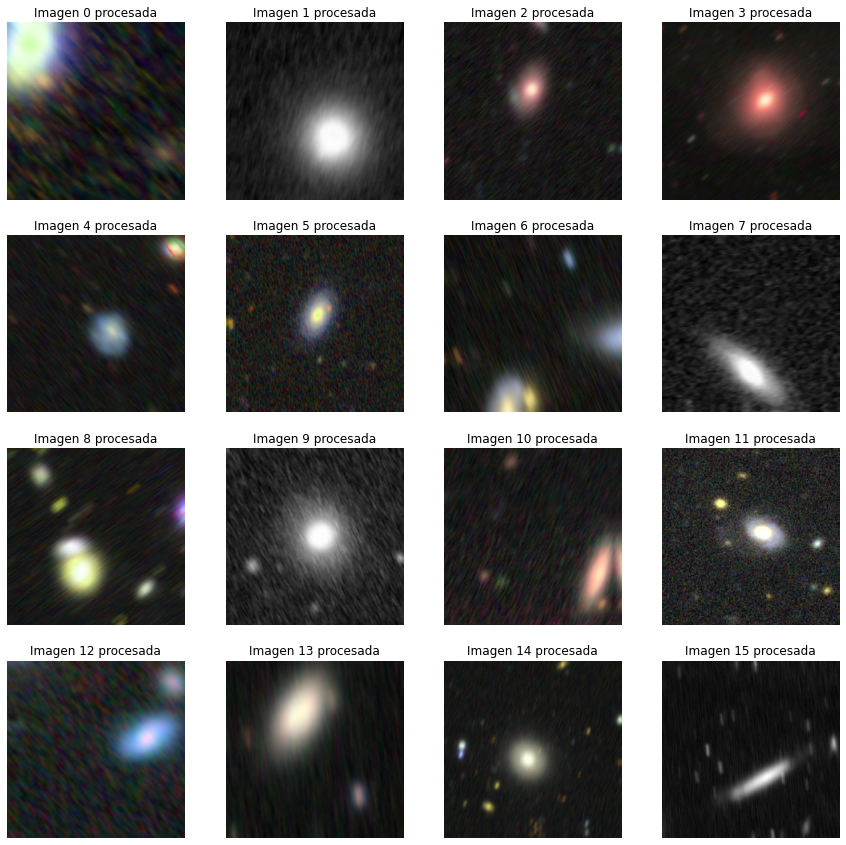

In [73]:
image_batch, label_batch = next(iter(ds))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} procesada'.format(i))
  plt.axis("off")

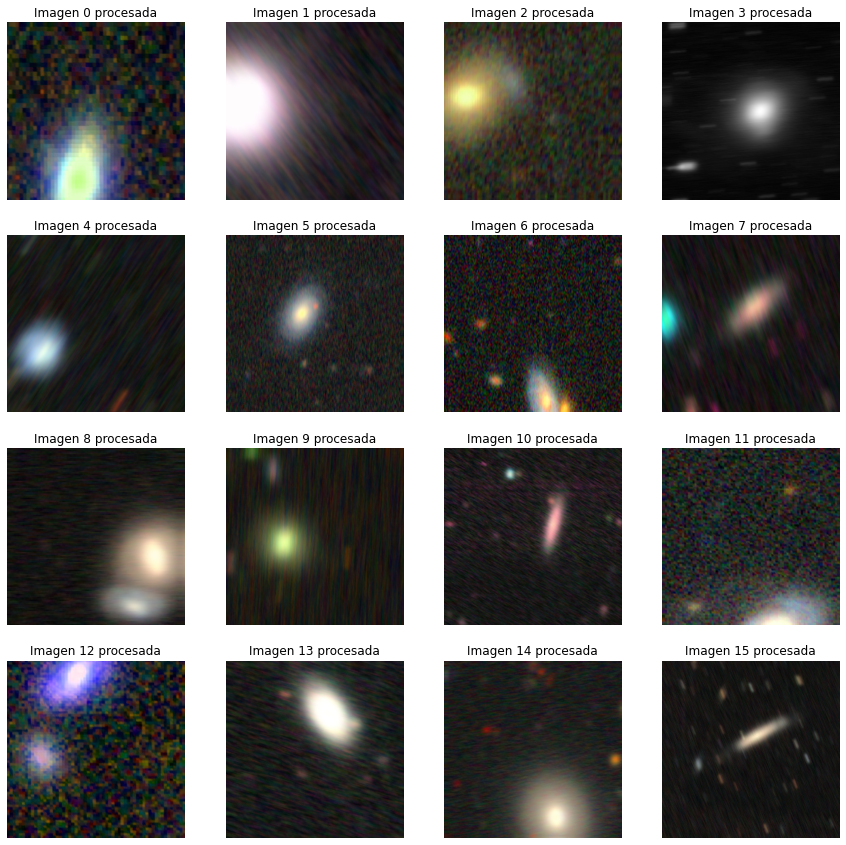

In [74]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to6[i])
  #label = label_batch[i]
  plt.title('Imagen {} procesada'.format(i))
  plt.axis("off")

In [8]:
image_batch

<tf.Tensor: shape=(16, 330, 330, 6), dtype=float32, numpy=
array([[[[0.10196079, 0.05098039, 0.0627451 , 0.10588235, 0.08235294,
          0.12156863],
         [0.1254902 , 0.02352941, 0.05882353, 0.11372549, 0.08235294,
          0.14509805],
         [0.12941177, 0.01960784, 0.05098039, 0.11372549, 0.08235294,
          0.14901961],
         ...,
         [0.08627451, 0.        , 0.11372549, 0.16078432, 0.11764706,
          0.14117648],
         [0.10588235, 0.        , 0.09803922, 0.16470589, 0.11372549,
          0.17254902],
         [0.1254902 , 0.01568628, 0.03529412, 0.15686275, 0.11764706,
          0.1764706 ]],

        [[0.14901961, 0.        , 0.01960784, 0.09411765, 0.08235294,
          0.10588235],
         [0.17254902, 0.        , 0.03529412, 0.09019608, 0.07843138,
          0.1254902 ],
         [0.17254902, 0.        , 0.03137255, 0.09019608, 0.07843138,
          0.12941177],
         ...,
         [0.21960784, 0.        , 0.03137255, 0.15686275, 0.11764706,
    